In [ ]:
import os
import json
import pandas as pd
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

# Verify that naslib is installed correctly
import naslib

# Reproducing the Zero-Cost Proxy Correlation plots

There are two ways to reproduce the correlation plots from the paper:

1. Re-run the experiments yourself and plot the results, or
2. Use the saved results to plot the results

We first look at the first option.

## 1. Run the correlation experiment

In this section, we will reproduce the results seen in the paper for NAS-Bench-201. You can modify the script to run it for all the benchmarks, but please be aware that it would take significantly longer to run the experiment for all of them.

### Step #1: Create the config files

To run the ZC proxy correlation experiments, we must first create the necessary config files. Afterwards, these files are consumed to run the experiments

In [ ]:
!cd .. && chmod +x ./scripts/bash_scripts/correlation/*.sh
!cd .. && ./scripts/bash_scripts/correlation/create_configs_nb201.sh

#Uncomment next line to create config files for all the benchmarks
#!cd .. && ./scripts/bash_scripts/correlation/create_configs_all.sh

### Step #2: Download NAS-Bench-Suite-Zero data files

In [ ]:
!cd .. && chmod +x ./scripts/bash_scripts/*.sh
!cd .. && ./scripts/bash_scripts/download_nbs_zero.sh nb201
# Uncomment the next line to download the queryable benchmarks for all the NAS benchmarks supported in NAS-Bench-Suite-Zero
#!cd .. && ./scripts/bash_scripts/download_nbs_zero.sh all

### Step #3: Run the experiments

We now consume the config files to run the experiments. 

Total number of runs = 13 proxies * 3 datasets * 5 seeds = 195. Each run should take no longer than 10 seconds.
The results of these runs can be found in ../run/correlation, which we later move to ../run/results/correlation

In [ ]:
%%bash
proxies=(flops params snip) # jacov grad_norm plain fisher grasp l2_norm nwot zen epe_nas synflow)
datasets=(cifar10 cifar100 ImageNet16-120)
seeds=(9001 9002 9003 9004 9005)
cd ..

for zc in "${proxies[@]}";
do
    for dataset in "${datasets[@]}";
    do
        for seed in "${seeds[@]}";
        do
#           echo $zc $dataset $seed
            python naslib/runners/runner.py --config-file configs/correlation/${zc}/nasbench201-9000/${dataset}/config_${seed}.yaml
        done
    done
done

In [ ]:
!mv ../run/correlation ../run/results/

## 2. Create plots with the saved results

If you do not wish to run the experiments yourself, you can use the saved results to create the plots. To do this, simply unzip NASLib/run/results/correlation_13proxies_all_benchmarks.zip and NASLib/run/results/correlation_9x.zip before running the rest of the code.

In [ ]:
# Uncomment these lines if you wish to use the saved results
!unzip -o ../run/results/correlation_13proxies_all_benchmarks.zip -d ../run/results/
!unzip -o ../run/results/correlation_9x.zip -d ../run/results/

In [167]:
BENCHMARKS = {
    'nasbench101': ['cifar10', ],
    'nasbench201': ['cifar10', 'cifar100', 'ImageNet16-120', 'ninapro', 'svhn', 'scifar100'],
    'nasbench301': ['cifar10', 'ninapro', 'svhn', 'scifar100'],
    'transbench101_micro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic', 'ninapro', 'svhn', 'scifar100'],
    'transbench101_macro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic']
}

LABELS = {
    'nasbench101': 'NB101',
    'nasbench201': 'NB201',
    'nasbench301': 'NB301',
    'transbench101_micro': 'TNB101_MICRO',
    'transbench101_macro': 'TNB101_MACRO',
    'cifar10': 'CF10',
    'cifar100': 'CF100',
    'ImageNet16-120': 'IMGNT',
    'jigsaw': 'JIGSAW',
    'class_scene': 'SCENE',
    'class_object': 'OBJECT',
    'autoencoder': 'AUTOENC',
    'normal': 'NORMAL',
    'room_layout': 'ROOM',
    'segmentsemantic': 'SEGMENT',
    'ninapro': 'NINAPRO',
    'svhn': 'SVHN',
    'scifar100': 'SCIFAR100'
}

START_SEED=9000
END_SEED=9010
TEST_SIZE=1000


In [168]:
def get_all_files(root_folder='../run/results/correlation', filename='scores.json'):
    """
        Function to get the paths to all scores.json inside the given root folder
    """
    all_files = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith(filename):
                #print(os.path.join(root, file))
                all_files.append(os.path.join(root, file))

    return all_files

def get_scores_as_list_of_dict(files):
    """
        Reads the given scores.json files and creates a dictionary for each one
    """
    data = []

    for file in files:
        file_components = file.split('/')
        search_space, dataset, predictor, seed = file_components[-5], file_components[-4], file_components[-3], file_components[-2]
        
        if int(seed) >= END_SEED or int(seed) < START_SEED:
#             print(f'Skipping {seed}')
            continue
        
        with open(file, 'r') as f:
            scores = json.load(f)[1]

        record = {
            'search_space': search_space,
            'dataset': dataset,
            'predictor': predictor,
            'seed': seed,
            'kendalltau': scores['kendalltau'],
            'pearson': scores['pearson'],
            'spearman': scores['spearman'],
            'preds': scores['full_testpred'],
            'ground_truth': scores['full_ytest'],
        }

        data.append(record)

    return data

def make_df(files):
    """
        Make a dataframe from the given scores.json files
    """
    data = get_scores_as_list_of_dict(files)
    df = pd.DataFrame(data)
    return df

def make_clean_df(preds_to_drop=None):
    """
        Make a dataframe from the all the scores.json files and clean it
    """
    files = get_all_files()
    df = make_df(files)

    wrong_len_indexes = []
    wrong_type_indexes = []

    if preds_to_drop is not None:
        for predictor in preds_to_drop:
            df = df[df['predictor'] != predictor]
    
    for idx in df.index:
        preds = df.loc[idx]['preds']
        if not isinstance(preds, list):
            wrong_type_indexes.append(idx)
        elif (len(preds) != 199) and (len(preds) != 192) and (len(preds) != TEST_SIZE):
            wrong_len_indexes.append(idx)

    bad_indices = wrong_len_indexes + wrong_type_indexes

    print(df.loc[wrong_type_indexes])
    df = df.drop(index=bad_indices)
    return df


In [169]:
# Create the dataframe from all the results
df = make_clean_df()

df['pearson'] = df['pearson'].fillna(0)
df['spearman'] = df['spearman'].fillna(0)
df['kendalltau'] = df['kendalltau'].fillna(0)

df

Empty DataFrame
Columns: [search_space, dataset, predictor, seed, kendalltau, pearson, spearman, preds, ground_truth]
Index: []


search_space  dataset predictor  seed  kendalltau   pearson  \
0     transbench101_micro   jigsaw    fisher  9009    0.187104  0.028595   
1     transbench101_micro   jigsaw    fisher  9007    0.223654  0.042834   
2     transbench101_micro   jigsaw    fisher  9000    0.205922  0.075128   
3     transbench101_micro   jigsaw    fisher  9001    0.221163  0.073054   
4     transbench101_micro   jigsaw    fisher  9006    0.190880  0.071359   
...                   ...      ...       ...   ...         ...       ...   
2582          nasbench101  cifar10   l2_norm  9008    0.367232  0.259429   
2583          nasbench101  cifar10   l2_norm  9003    0.391343  0.217211   
2584          nasbench101  cifar10   l2_norm  9004    0.372463  0.302301   
2585          nasbench101  cifar10   l2_norm  9005    0.321183  0.195865   
2586          nasbench101  cifar10   l2_norm  9002    0.341995  0.224733   

      spearman                                              preds  \
0     0.294289  [9.097240447998047, 15.123231887817383, 3.7469...   
1     0.342062  [3.785313129425049, 18.19780731201172, 8.77759...   
2     0.313097  [58.21249771118164, 14.150123596191406, 94.524...   
3     0.334281  [537.9170532226562, 6.107849597930908, 45.4315...   
4     0.293660  [9.50398063659668, 43.28057098388672, 4.076462...   
...        ...                                                ...   
2582  0.523239  [1144.1207275390625, 958.3194580078125, 1200.0...   
2583  0.551942  [1006.7098388671875, 1189.52197265625, 1650.25...   
2584  0.523747  [993.926025390625, 947.93310546875, 1006.71240...   
2585  0.457369  [687.2852172851562, 798.8533325195312, 349.117...   
2586  0.485498  [763.3030395507812, 648.85107421875, 1226.5037...   

                                           ground_truth  
0     [70.93949127197266, 94.19287872314453, 93.6056...  
1     [93.81966400146484, 86.83319854736328, 91.9386...  
2     [90.455810546875, 92.68511199951172, 93.620620...  
3     [83.2304916381836, 75.64192199707031, 92.41142...  
4     [93.78981018066406, 93.54598236083984, 77.7667...  
...                                                 ...  
2582  [92.68830418586731, 88.47155570983887, 94.0204...  
2583  [93.43950152397156, 87.92067170143127, 91.3862...  
2584  [91.18589758872986, 90.11418223381042, 92.5881...  
2585  [90.50480723381042, 89.0625, 86.35817170143127...  
2586  [91.61658883094788, 90.41466116905212, 93.0388...  

[2587 rows x 9 columns]

In [170]:
def plot_heatmap(df, figsize=(20, 10), rotation=0, title='', cmap='viridis_r', savetitle='zcp_corr', horizontal_align='right', cbar=True, square=False, fmt='.2f'):
    """
        Plots the heatmap from the given dataframe
    """
    plt.figure(figsize=figsize, dpi=200)
    plt.title(title, fontsize=20)
    heatmap = sns.heatmap(df, annot=True, cmap=cmap, fmt=fmt, cbar=False, square=square)
    for tick in heatmap.get_xticklabels():
        tick.set_fontname("monospace")
    for tick in heatmap.get_yticklabels():
        tick.set_fontname("monospace")
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=rotation, fontsize=12, horizontalalignment=horizontal_align)
    heatmap.set(xlabel=None)
    heatmap.set(ylabel=None)
    plt.tight_layout()
    plt.savefig('{}.pdf'.format(savetitle), bbox_inches='tight') 

def plot_heatmap_for_benchmark(df, search_space, dataset, corr_type):
    """
        Plots the pearson correlation between pairs of zero-cost proxies for a given benchmark (i.e., combination of 
        search space and dataset)
    """
    _df = df[(df['search_space'] == search_space) & (df['dataset'] == dataset)][['predictor', 'seed', corr_type]]
    pivot_df = _df.pivot_table(corr_type, 'seed', 'predictor')
    plot_heatmap(pivot_df.corr(), title=f'Pearson correlation between rank correlations for {search_space}-{dataset}')

def compute_correlation(df, predictors):
    """
        Computes the correlation coefficient matrix between all pairs of zero-cost proxies
    """
    corr = np.zeros((len(predictors), len(predictors)))
    for i in range(len(predictors)):
        for j in range(len(predictors)):
            zc_1 = predictors[i]
            zc_2 = predictors[j]

            preds_1 = np.array(df[df['predictor'] == zc_1]['preds'].to_list()[0])
            preds_2 = np.array(df[df['predictor'] == zc_2]['preds'].to_list()[0])
            
            try:
                if len(preds_1) != len(preds_2):
                    print(zc_1, zc_2, len(zc_1), len(zc_2), 'prediction sizes do not match')
                    continue
            except:
                print(zc_1, preds_1)
                print(zc_2, preds_2)
                
            coeff = np.corrcoef(preds_1, preds_2)[0, 1]

            corr[i, j] = coeff

    return corr

def make_search_space_predictors_df(df, metric, benchmarks):
    """
        Averages the values across the different seeds and creates a dataframe
        which can be used to plot the correlation heatmap
    """
    pred_scores = df.groupby(['search_space', 'dataset', 'predictor'])[metric].mean()

    series = []
    for searchspace, datasets in benchmarks.items():
        for dataset in datasets:
            #print(searchspace, dataset)
            if searchspace in pred_scores and dataset in pred_scores[searchspace]:
                series.append(pred_scores[searchspace][dataset].rename(f'{LABELS[searchspace]}-{LABELS[dataset]}'))

    # Concatenate all the series from left to right to get the dataframe
    # with datasets as the columns and 
    idf = series[0].to_frame()

    for idx, s in enumerate(series):
        if idx == 0:
            continue

        idf = idf.merge(s.to_frame(), left_index=True, right_index=True)

    return idf

In [171]:
pred_df = make_search_space_predictors_df(df, 'spearman', BENCHMARKS)
df

search_space  dataset predictor  seed  kendalltau   pearson  \
0     transbench101_micro   jigsaw    fisher  9009    0.187104  0.028595   
1     transbench101_micro   jigsaw    fisher  9007    0.223654  0.042834   
2     transbench101_micro   jigsaw    fisher  9000    0.205922  0.075128   
3     transbench101_micro   jigsaw    fisher  9001    0.221163  0.073054   
4     transbench101_micro   jigsaw    fisher  9006    0.190880  0.071359   
...                   ...      ...       ...   ...         ...       ...   
2582          nasbench101  cifar10   l2_norm  9008    0.367232  0.259429   
2583          nasbench101  cifar10   l2_norm  9003    0.391343  0.217211   
2584          nasbench101  cifar10   l2_norm  9004    0.372463  0.302301   
2585          nasbench101  cifar10   l2_norm  9005    0.321183  0.195865   
2586          nasbench101  cifar10   l2_norm  9002    0.341995  0.224733   

      spearman                                              preds  \
0     0.294289  [9.097240447998047, 15.123231887817383, 3.7469...   
1     0.342062  [3.785313129425049, 18.19780731201172, 8.77759...   
2     0.313097  [58.21249771118164, 14.150123596191406, 94.524...   
3     0.334281  [537.9170532226562, 6.107849597930908, 45.4315...   
4     0.293660  [9.50398063659668, 43.28057098388672, 4.076462...   
...        ...                                                ...   
2582  0.523239  [1144.1207275390625, 958.3194580078125, 1200.0...   
2583  0.551942  [1006.7098388671875, 1189.52197265625, 1650.25...   
2584  0.523747  [993.926025390625, 947.93310546875, 1006.71240...   
2585  0.457369  [687.2852172851562, 798.8533325195312, 349.117...   
2586  0.485498  [763.3030395507812, 648.85107421875, 1226.5037...   

                                           ground_truth  
0     [70.93949127197266, 94.19287872314453, 93.6056...  
1     [93.81966400146484, 86.83319854736328, 91.9386...  
2     [90.455810546875, 92.68511199951172, 93.620620...  
3     [83.2304916381836, 75.64192199707031, 92.41142...  
4     [93.78981018066406, 93.54598236083984, 77.7667...  
...                                                 ...  
2582  [92.68830418586731, 88.47155570983887, 94.0204...  
2583  [93.43950152397156, 87.92067170143127, 91.3862...  
2584  [91.18589758872986, 90.11418223381042, 92.5881...  
2585  [90.50480723381042, 89.0625, 86.35817170143127...  
2586  [91.61658883094788, 90.41466116905212, 93.0388...  

[2587 rows x 9 columns]

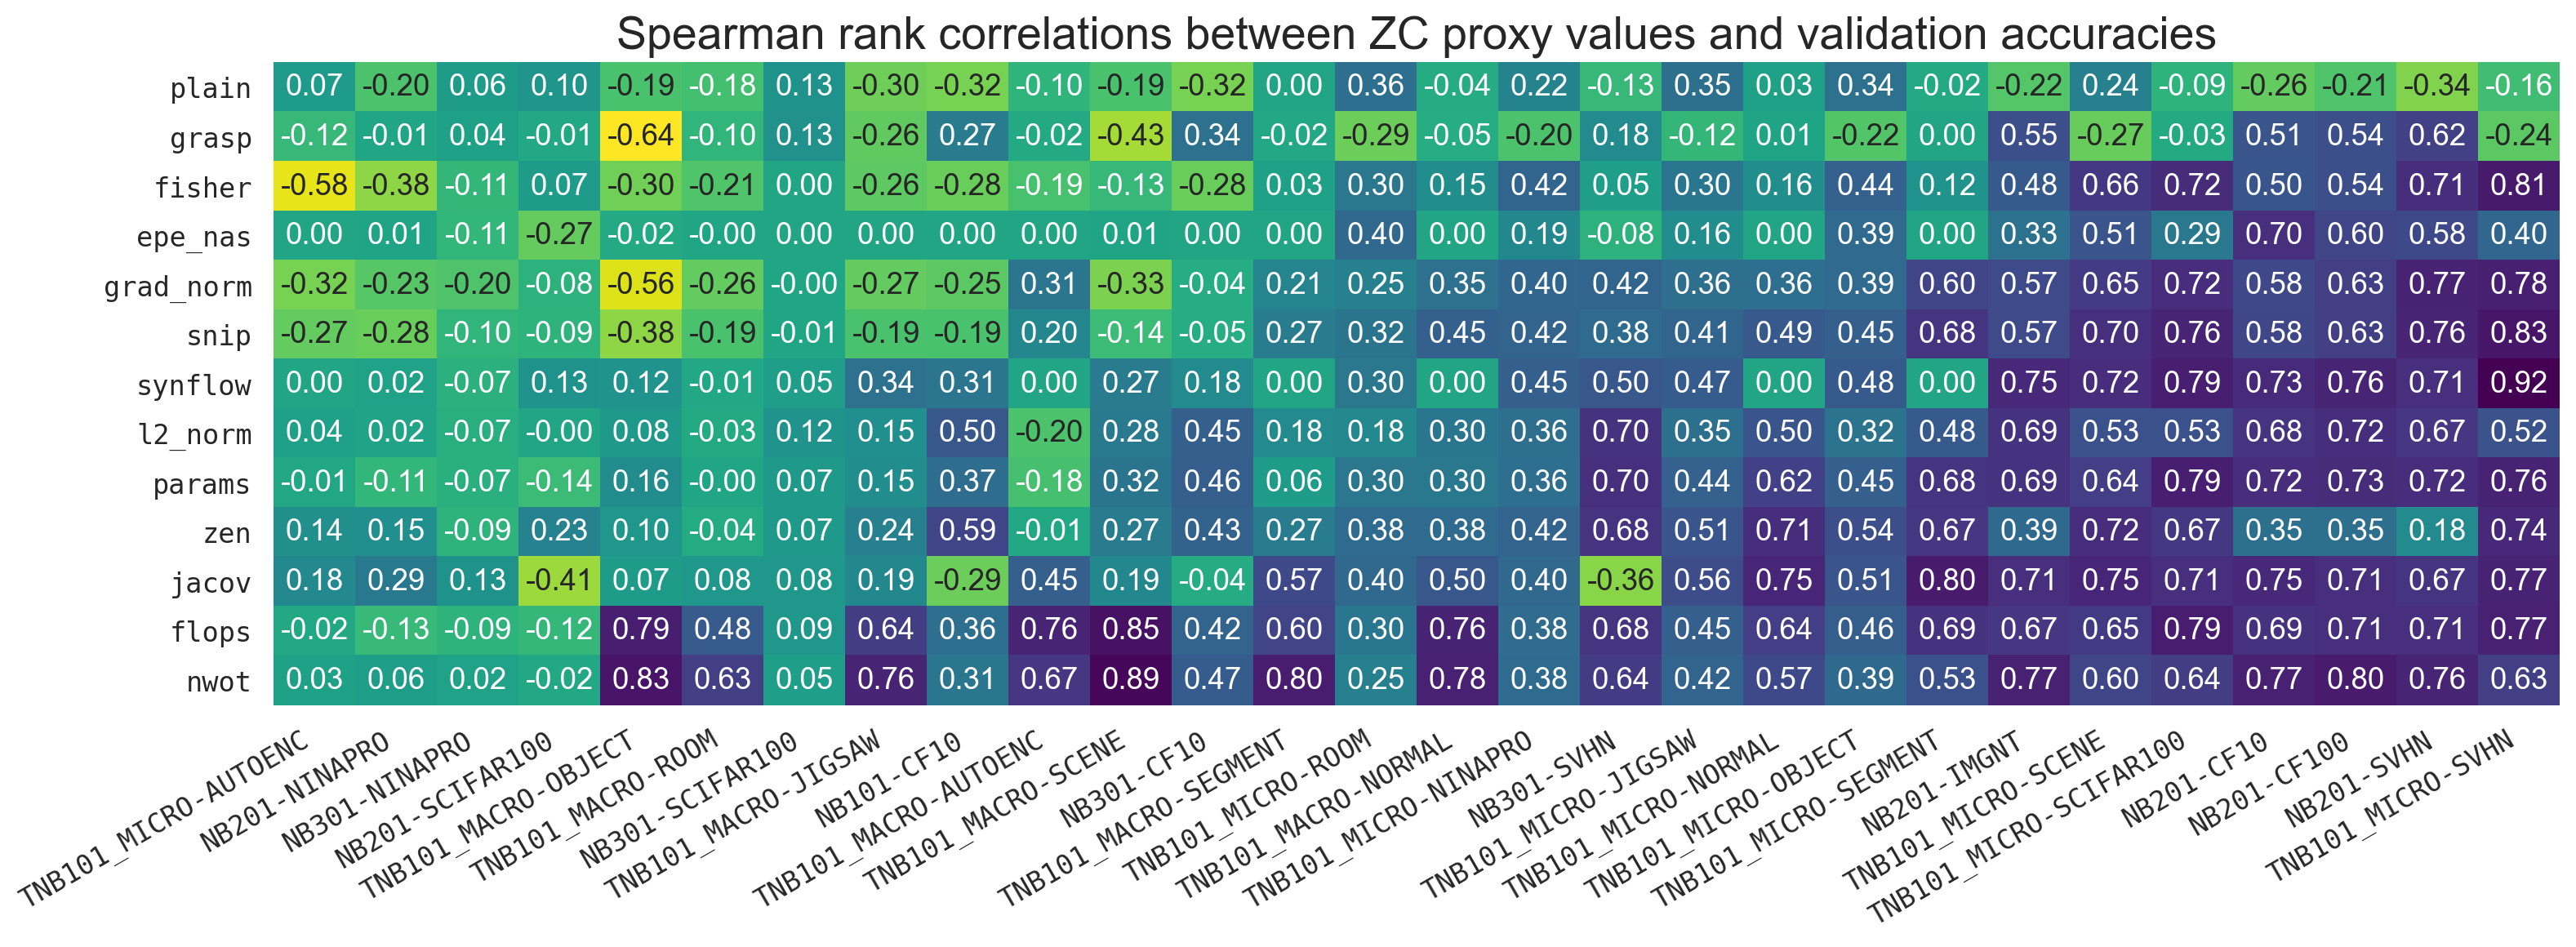

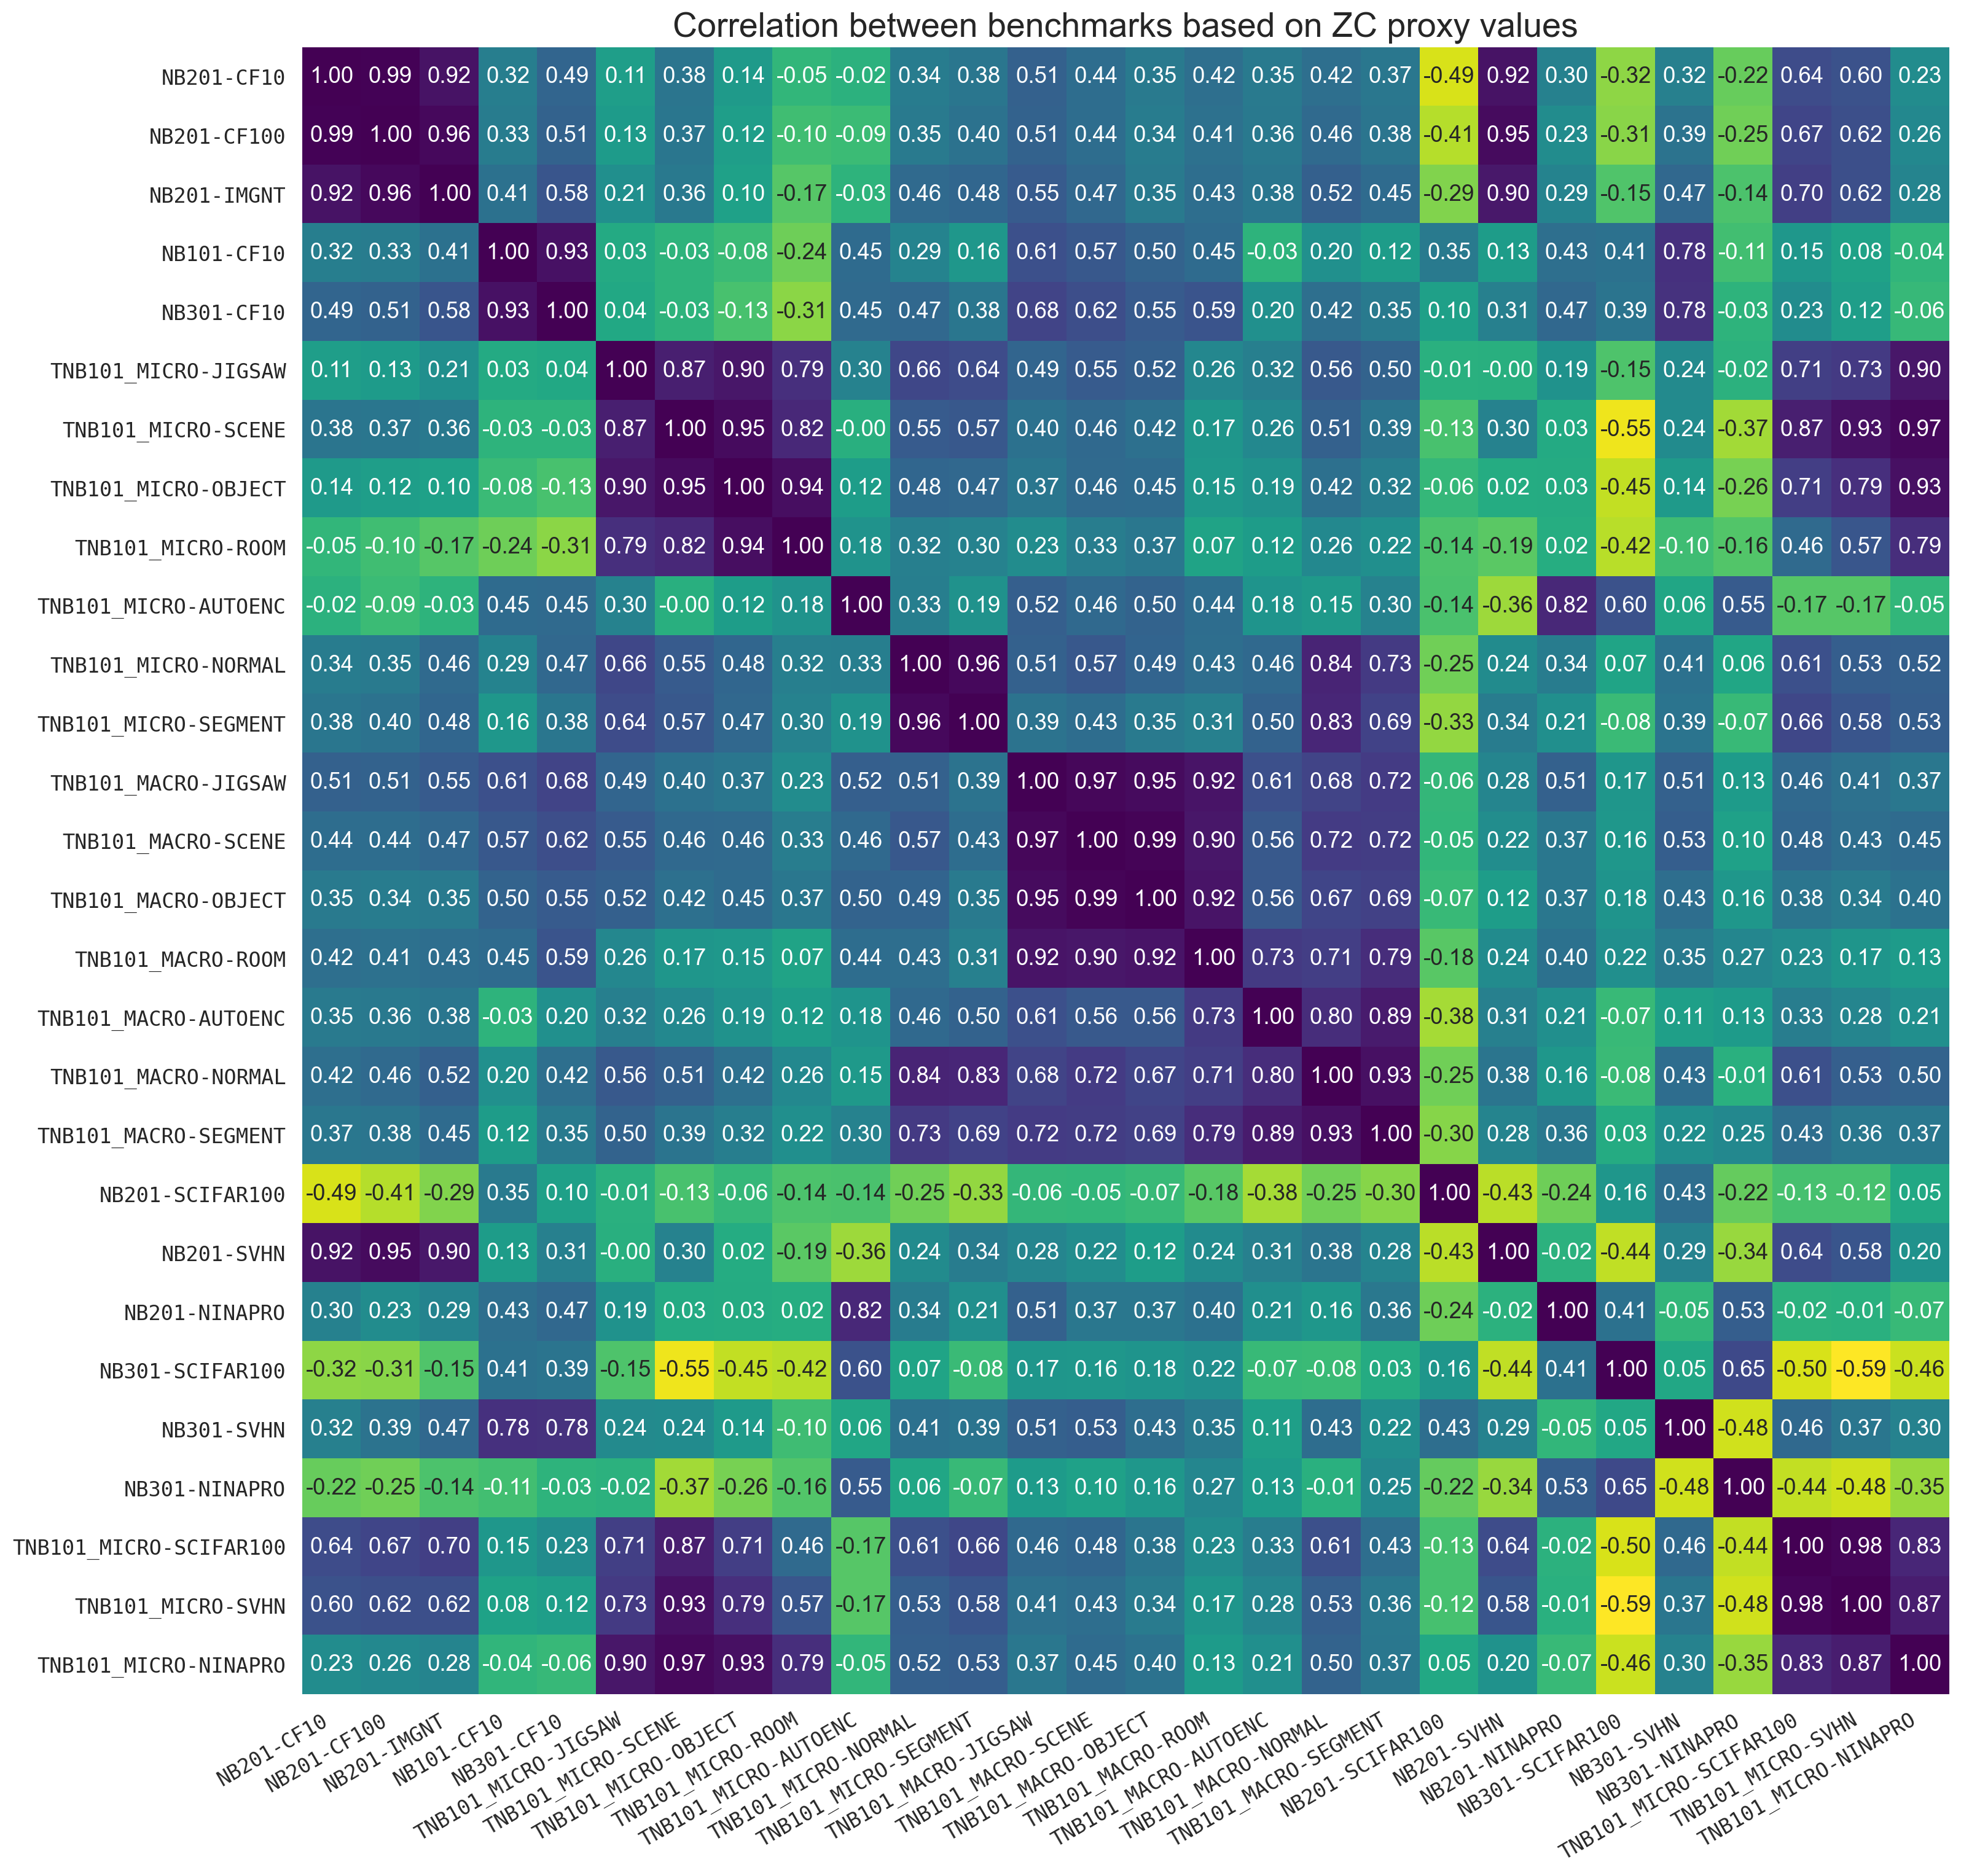

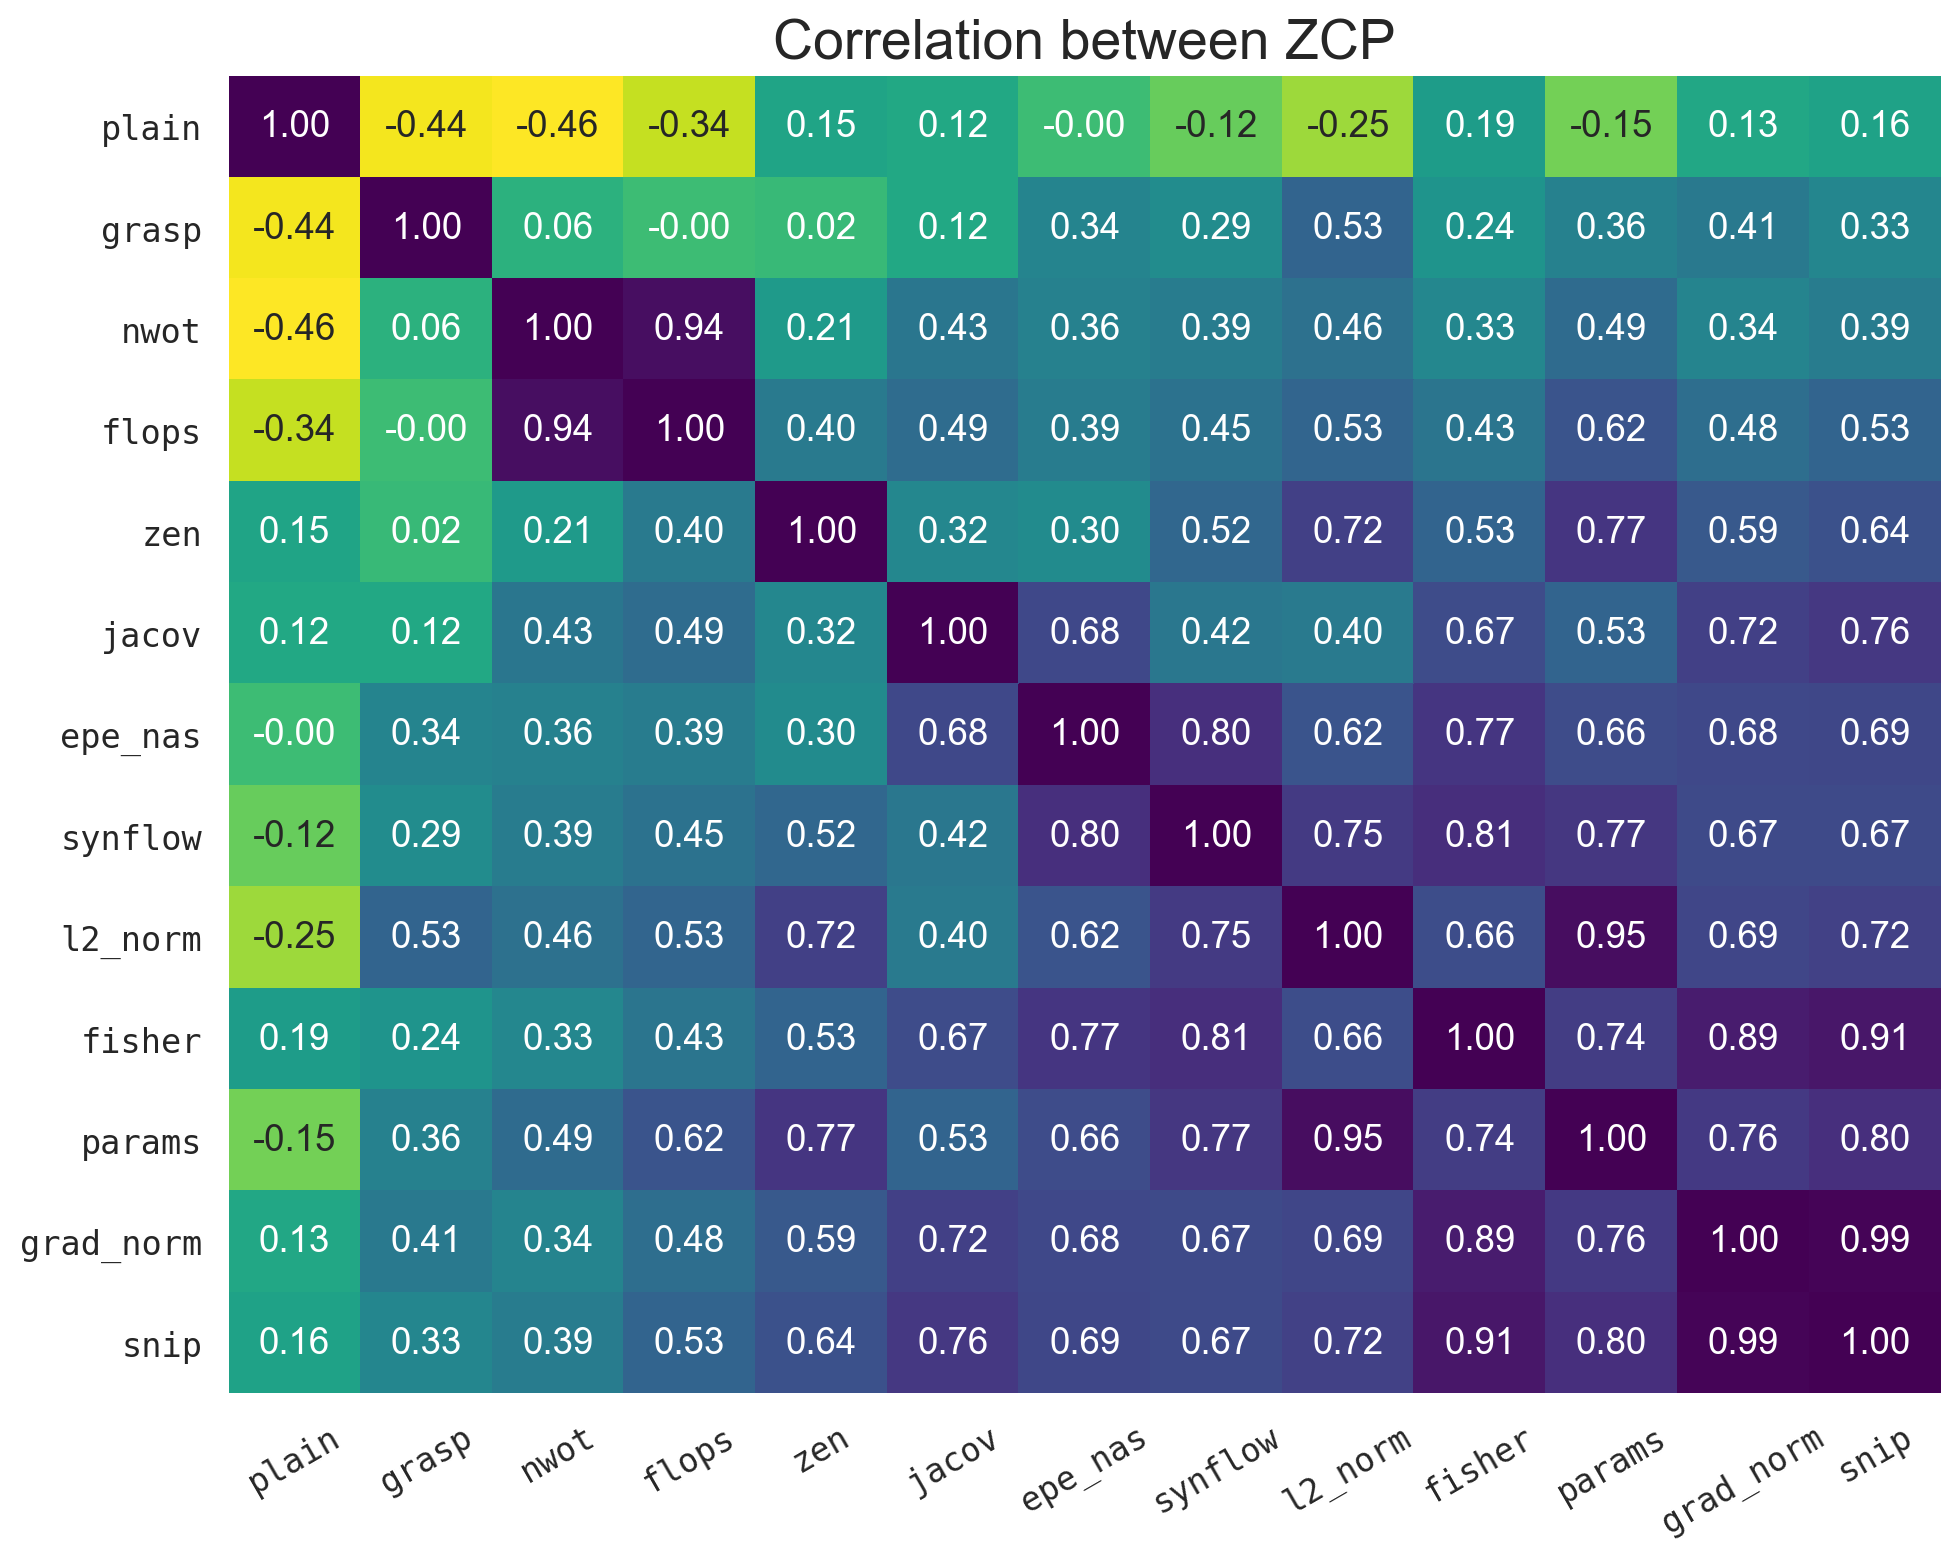

In [172]:
sns.set(font_scale=1.1)
order = ['NB201-CF10', 'NB201-CF100', 'NB201-IMGNT',
        # Comment the following lines if you ran only the experiments for NB201
       'NB101-CF10', 'NB301-CF10',
       'TNB101_MICRO-JIGSAW', 'TNB101_MICRO-SCENE', 'TNB101_MICRO-OBJECT',
       'TNB101_MICRO-ROOM', 'TNB101_MICRO-AUTOENC', 'TNB101_MICRO-NORMAL', 
       'TNB101_MICRO-SEGMENT', 'TNB101_MACRO-JIGSAW', 'TNB101_MACRO-SCENE',
       'TNB101_MACRO-OBJECT', 'TNB101_MACRO-ROOM', 'TNB101_MACRO-AUTOENC',
       'TNB101_MACRO-NORMAL', 'TNB101_MACRO-SEGMENT',
       'NB201-SCIFAR100', 'NB201-SVHN', 'NB201-NINAPRO',
       'NB301-SCIFAR100', 'NB301-SVHN', 'NB301-NINAPRO',
       'TNB101_MICRO-SCIFAR100', 'TNB101_MICRO-SVHN', 'TNB101_MICRO-NINAPRO',]

def sort_by_mean(df):
    """
        Used to sort the rows and columns of the df so that the plot is more readable
    """
    df = df.reindex(df.transpose().mean().sort_values().index)
    df = df.reindex(df.mean().sort_values().index, axis=1)
    return df

pred_df1 = sort_by_mean(pred_df)
plot_heatmap(pred_df1, figsize=(16, 6), rotation=30,
             title='Spearman rank correlations between ZC proxy values and validation accuracies')

pred_df_bench = pred_df.corr()
pred_df_bench = pred_df_bench.reindex(columns=order, index=order)

plot_heatmap(pred_df_bench, figsize=(16, 16), rotation=30, savetitle='bench_xcorr',
             title='Correlation between benchmarks based on ZC proxy values', cbar=False, square=True)

pred_df_corr = pred_df.transpose().corr()
pred_df_corr = sort_by_mean(pred_df_corr)
plot_heatmap(pred_df_corr, figsize=(10, 8), rotation=30, savetitle='zcp_xcorr',
             title='Correlation between ZCP', horizontal_align='center')

# plot_heatmap_for_benchmark(df, 'nasbench201', 'cifar10', 'spearman')
# plot_heatmap_for_benchmark(df, 'nasbench201', 'cifar100', 'spearman')
# plot_heatmap_for_benchmark(df, 'nasbench201', 'ImageNet16-120', 'spearman')
# plot_heatmap_for_benchmark(df, 'nasbench301', 'cifar10', 'spearman')
# plot_heatmap_for_benchmark(df, 'nasbench101', 'cifar10', 'spearman')
# plot_heatmap_for_benchmark(df, 'transbench101_micro', 'jigsaw', 'spearman')
# pred_df